<a href="https://colab.research.google.com/github/itsalanthomas/shipping-optimization/blob/dev/notebooks/E_Commerce_Optimization_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# load libraries
from google.colab import files
from io import StringIO
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# load data in with file simulation
uploaded = files.upload()
filename = 'ecommerce_shipping.csv'

with open(filename, 'r') as file:
  csv_text = file.read()

# create df
df = pd.read_csv(StringIO(csv_text))
df


Saving ecommerce_shipping.csv to ecommerce_shipping (4).csv


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0


In [24]:
## EDA - Exploratory Data Analysis ##
df.info()
df.describe()
df.isnull().sum() #check count of null values in columns
df[df.isnull().any(axis = 1)] #check if there are any missing values in rows

# rename columns
df.columns = [col.strip().replace('_', ' ').title() for col in df.columns]
df.rename(columns={'Reached.On.Time Y.N': 'On-Time Delivery'},inplace=True)

# new features engineered
df['Net Price'] = round(df['Cost Of The Product'] - df['Discount Offered'],2) # net price
df['Discount Ratio'] = round((df['Discount Offered']/df['Cost Of The Product']), 2) # % of product cost discounted

# late rate grouped by mode of shipment
late_rate_lookup = (
    df.groupby('Mode Of Shipment')['On-Time Delivery']
    .mean() # 1 - not on time , 0 - on time
    .to_dict()
)
df['Status By Mode Of Shipment'] = round(df['Mode Of Shipment'].map(late_rate_lookup),2)
df[['Discount Ratio','Net Price','Cost Of The Product','Discount Offered', 'Status By Mode Of Shipment']].head(5)

# customize logic for label encoding feature
product_order = {'low': 0 ,'medium':1, 'high':2}
df['Product Importance'] = df['Product Importance'].map(product_order)

df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Id                          10999 non-null  int64  
 1   Warehouse Block             10999 non-null  object 
 2   Mode Of Shipment            10999 non-null  object 
 3   Customer Care Calls         10999 non-null  int64  
 4   Customer Rating             10999 non-null  int64  
 5   Cost Of The Product         10999 non-null  int64  
 6   Prior Purchases             10999 non-null  int64  
 7   Product Importance          10999 non-null  int64  
 8   Gender                      10999 non-null  object 
 9   Discount Offered            10999 non-null  int64  
 10  Weight In Gms               10999 non-null  int64  
 11  On-Time Delivery            10999 non-null  int64  
 12  Net Price                   10999 non-null  int64  
 13  Discount Ratio              109

,Id,Warehouse Block,Mode Of Shipment,Customer Care Calls,Customer Rating,Cost Of The Product,Prior Purchases,Product Importance,Gender,Discount Offered,Weight In Gms,On-Time Delivery,Net Price,Discount Ratio,Status By Mode Of Shipment
0,1,D,Flight,4,2,177,3,NaN,F,44,1233,1,133,0.25,0.6
1,2,F,Flight,4,5,216,2,NaN,M,59,3088,1,157,0.27,0.6
2,3,A,Flight,2,2,183,4,NaN,M,48,3374,1,135,0.26,0.6
3,4,B,Flight,3,3,176,4,NaN,M,10,1177,1,166,0.06,0.6
4,5,C,Flight,2,2,184,3,NaN,F,46,2484,1,138,0.25,0.6


In [ ]:
#Checking most profitable warehouse
warehouse_totals = df.groupby('Warehouse Block')['Net Price'].sum()
print(warehouse_totals)

df['Discount Ratio'].dtype

Warehouse Block
A    358434
B    364716
C    362552
D    362791
F    716370
Name: Net Price, dtype: int64


dtype('float64')

Text(0.5, 1.0, 'On-time Delivery by Warehouse Block')

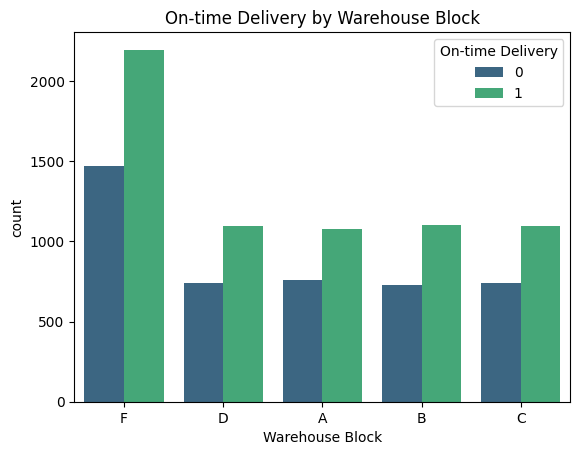

In [ ]:
#Counts for warehouse blocks
order = df['Warehouse Block'].value_counts().index
sns.countplot(x='Warehouse Block', data=df, palette='viridis', hue='On-time Delivery', order = order)
plt.title('On-time Delivery by Warehouse Block')

Text(0.5, 1.0, 'On-time Delivery by Mode of Shipment')

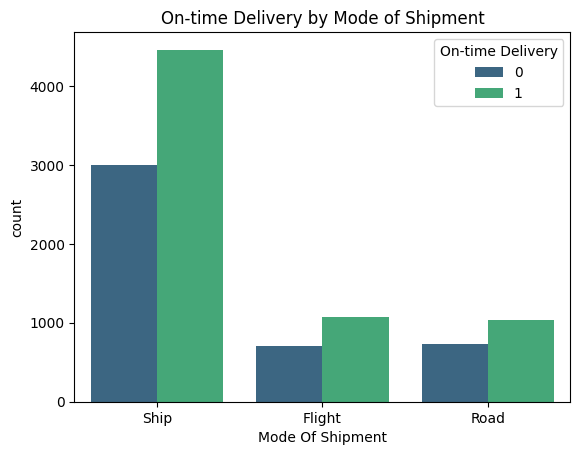

In [ ]:
# Counts for mode of shipment
order  = df['Mode Of Shipment'].value_counts().index
sns.countplot(x='Mode Of Shipment', data=df, palette='viridis', hue='On-time Delivery', order = order)
plt.title('On-time Delivery by Mode of Shipment')

<Axes: xlabel='Product Importance', ylabel='count'>

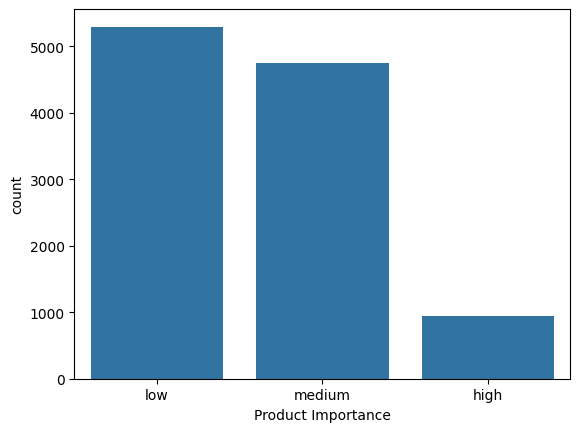

In [ ]:
#Count plot for Product Importance
sns.countplot(x = df['Product Importance'], data = df)

Text(0.5, 1.0, 'Weight in grams distribution')

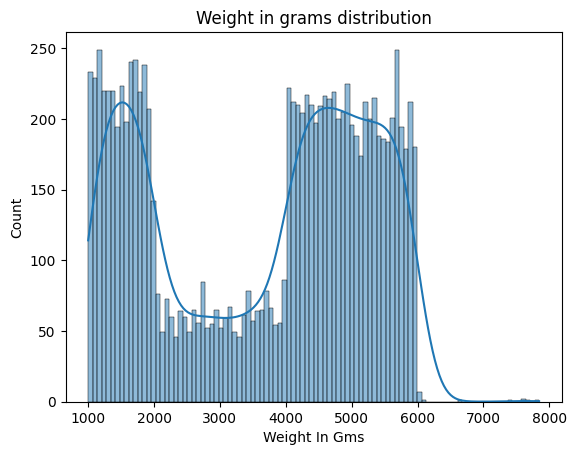

In [ ]:
#Hist plot for the weight in grams....seems to be a bimodal distribution with some outliers
sns.histplot(df['Weight In Gms'],bins = 100,kde = True)
plt.title('Weight in grams distribution')

<ipython-input-64-2c503e070b55>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Warehouse Block', y='Weight In Gms', data=df, palette='Set2')


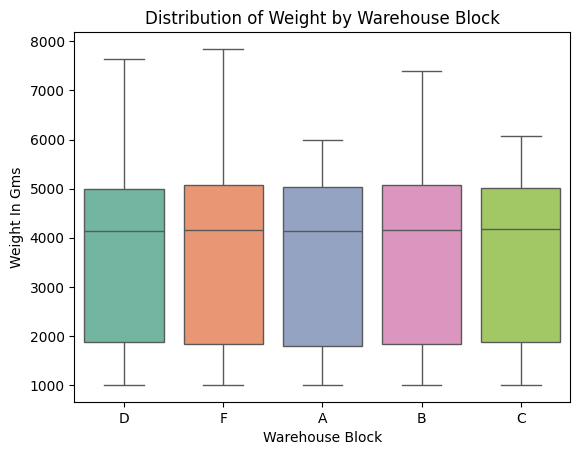

In [ ]:
#Bit more distribution...Most 50% range is the same for all of them.
sns.boxplot(x='Warehouse Block', y='Weight In Gms', data=df, palette='Set2')
plt.title('Distribution of Weight by Warehouse Block')
plt.show()

In [ ]:
#Checking for outliers using the IQR method

q1 = df['Weight In Gms'].quantile(0.25)
q3 = df['Weight In Gms'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['Weight In Gms'] < lower_bound) | (df['Weight In Gms'] > upper_bound)]

print("Number of outliers:", outliers.shape[0])

Number of outliers: 0


<Axes: xlabel='Product Importance', ylabel='count'>

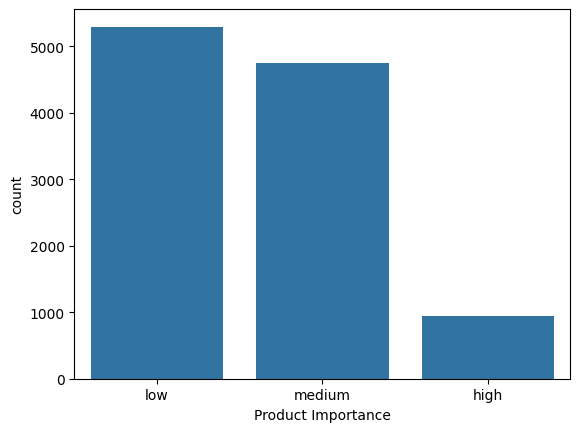

In [ ]:
sns.countplot(x = df['Product Importance'], data = df)


<ipython-input-68-9a461536121e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df['On-time Delivery'], data = df, palette='viridis')


Text(0.5, 1.0, 'On-time Delivery Counts')

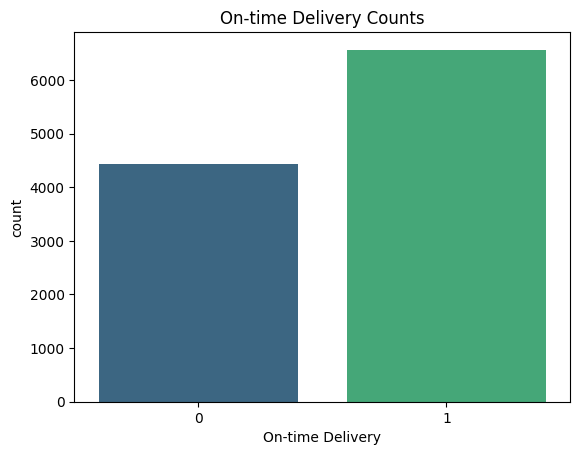

In [ ]:
sns.countplot(x = df['On-time Delivery'], data = df, palette='viridis')
plt.title('On-time Delivery Counts')

In [ ]:
df['Warehouse Block'].value_counts()

,count
Warehouse Block,
F,3666
D,1834
A,1833
B,1833
C,1833


In [ ]:
# PREPROCESSING PART? IS EDA done starting here? maybe we can also include the engineereed features starting here?
# customize logic for label encoding feature
product_order = {'low': 0 ,'medium':1, 'high':2}
df['Product Importance'] = df['Product Importance'].map(product_order)

In [ ]:
# OneHot encode features
columns = ['Warehouse Block','Mode Of Shipment', 'Gender']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_array = encoder.fit_transform(df[columns])

encoded_df = pd.DataFrame(encoded_array, columns = encoder.get_feature_names_out(columns))

df_new = pd.concat([df.drop(columns = columns), encoded_df], axis = 1)

In [ ]:
# standarize/scale numeric values
scaler = StandardScaler()
columns_to_scale = ['Customer Care Calls','Customer Rating',
                    'Cost Of The Product','Prior Purchases',
                    'Product Importance','Discount Offered',
                    'Weight In Gms', 'Net Price','Discount Ratio']
df_new_scaled = scaler.fit_transform(df_new[columns_to_scale])
df_new_scaled = pd.DataFrame(df_new_scaled, columns = columns_to_scale)
df_new_scaled = pd.concat([df_new.drop(columns = columns_to_scale), df_new_scaled], axis = 1)

In [ ]:
#Checking for multicollinearity values greater than 5 (ignoring the total price since that was created from two other features)
#taking out correlated columns (price ones)
df_vif = df_new_scaled.drop(columns = ['Net Price','Cost Of The Product','Discount Offered'])

vif = pd.DataFrame()
vif['feature']  = df_vif.columns
vif['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
print(vif)

                  feature       VIF
0                      Id  3.978197
1        On-time Delivery  2.501961
2       Warehouse Block_B  1.712910
3       Warehouse Block_C  1.706994
4       Warehouse Block_D  1.705543
5       Warehouse Block_F  2.417042
6   Mode Of Shipment_Road  1.675908
7   Mode Of Shipment_Ship  3.885278
8                Gender_M  1.881219
9     Customer Care Calls  1.197706
10        Customer Rating  1.000754
11        Prior Purchases  1.084521
12     Product Importance  1.020081
13          Weight In Gms  1.334823
14              Cost Rate  1.110757


In [ ]:
#Drop the columns that are linearly correlated and target variable.
X = df_new_scaled.drop(columns = ['On-time Delivery','Cost Of The Product','Discount Offered','Id'])\
    .assign(High_Discount=df['High Discount'].values)
y = df_new_scaled['On-time Delivery']

In [ ]:
#Splitting data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

In [ ]:
#Create Model
model_logreg = LogisticRegression()

#train model
model_logreg.fit(X_train, y_train)

#predict
y_pred = model_logreg.predict(X_test)

In [ ]:
print('Accuracy:', round(accuracy_score(y_test, y_pred),2))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.63
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.44      0.48      1312
           1       0.67      0.75      0.71      1988

    accuracy                           0.63      3300
   macro avg       0.60      0.60      0.60      3300
weighted avg       0.62      0.63      0.62      3300



In [ ]:
# Compute the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[ 577  735]
 [ 495 1493]]


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0
